In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd

import psycopg2
from fiona.crs import from_epsg

from netrc import netrc
user, acct, passwd = netrc().authenticators("harris")

import requests

import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
geo_tracts = gpd.read_postgis("SELECT state::bigint * 1000000000 + county * 1000000 + tract geoid, "
                              "ST_Transform(geom, 3528) geom "
                              "FROM census_tracts_2015 "
                              "WHERE state = 17 AND county = 31;",
                              con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                     host = "saxon.harris.uchicago.edu", port = 5432),
                              index_col = "geoid", geom_col = "geom", crs = from_epsg(3528))

chicago = gpd.read_file("chicago.geojson").to_crs(epsg = 3528).unary_union
chi_tracts = sorted(list(geo_tracts[geo_tracts.centroid.within(chicago)].index))

In [3]:
# O'Hare, Midway, and Robert Taylor Park.
empty_tracts = [17031381700, 17031980000, 17031980100]

traces = pd.read_csv("c_adjacencies.csv", names = ["h", "GEOID", "a"])

mtraces = traces.pivot(index = "h", columns = "GEOID", values = "a").fillna(0).sort_index()
mtraces.drop(empty_tracts, inplace = True)
mtraces = mtraces[list(mtraces.index)]

for tr in list(mtraces.index): mtraces.loc[tr, tr] = 0

mtraces = mtraces.div(mtraces.sum(axis=1), axis=0)
np_mtraces = mtraces.as_matrix()

## Now Grab Census Characteristics

In [4]:
census_vars = {"DP02_0086E" : "TOTAL_POP",
               "DP02_0066PE" : "HS_PCT", "DP02_0067PE" : "BA_PCT", "DP02_0065PE" : "ADV_PCT",
               "DP03_0062E" : "MHI", "DP03_0119PE" : "POV_PCT",
               "DP05_0060PE" : "PCT_BLACK", "DP05_0066PE" : "PCT_HISP",
               "DP03_0009PE" : "PCT_UNEMP"
              }

census_vals = list(census_vars.values())

census_labels = {"HS_PCT" : "HS Graduate [%]", "BA_PCT" : "Bachelor's Degree [%]", "ADV_PCT" : "Advanced Degree [%]",
                 "MHI" : "Median Household Income [k$]", "POV_PCT" : "Under the Poverty Line [%]",
                 "PCT_BLACK" : "Black [%]", "PCT_HISP" : "Hispanic [%]",
                 "PCT_UNEMP" : "Unemployment Rate [%]"}

url = "https://api.census.gov/data/2014/acs5/profile?for=tract:*&in=state:{}+county:{}&get=NAME,"
url = url + ",".join(census_vars.keys())

dfs = []
for cs in (mtraces.columns // 1000000).unique():
    
    print(cs, end = " ")
    state, county = (cs // 1000), (cs % 1000)

    # print(url.format(state, county))

    j = requests.get(url.format(state, county)).json()
    df = pd.DataFrame(j[1:], columns = j[0])
    df.rename(columns = census_vars, inplace = True)

    dfs.append(df)

df = pd.concat(dfs)

for v in list(census_vars.values()) + ["state", "county", "tract"]:
    df[v] = pd.to_numeric(df[v], errors = "coerce")
    
df["MHI"] /= 1e3

df["GEOID"] = df["state"] * 1000000000 + df["county"] * 1000000 + df["tract"]
df.set_index("GEOID", inplace = True)
df.index.name = "GEOID"

df.to_csv("ana_data/chicago_base_vars.csv")

data = df.loc[mtraces.index]
data.index.name = "GEOID"

17031 17043 17089 17093 17197 18089 

## Get the weighted, lagged rates.

In [5]:
lagged = pd.DataFrame(data = np.matmul(np_mtraces, data[census_vals]), columns = census_vals, index = mtraces.index)
lagged = df[census_vals].join(lagged, rsuffix = "_lag").loc[chi_tracts].dropna()

In [6]:
for k, v in census_labels.items():
    
    ax = lagged.plot(kind = "scatter", x = k, y = k + "_lag", alpha = 0.2)
    ax.set_aspect("equal")
    ax.set_ylabel("Lagged")
    ax.set_xlabel(v)

    ax.figure.savefig("figs/lag_" + k + ".pdf")
    
    plt.close("all")

## Show all the interactions -- no average.

In [7]:
traces = pd.read_csv("c_adjacencies.csv", names = ["h", "o", "a"])
traces = traces[traces.h != traces.o]

mtraces = traces.pivot(index = "h", columns = "o", values = "a").fillna(0).sort_index()
mtraces.drop(empty_tracts, inplace = True)
mtraces = mtraces[list(mtraces.index)]
mtraces = mtraces.div(mtraces.sum(axis=1), axis=0)

In [8]:
traces = mtraces.stack().reset_index()
traces.rename(columns = {0 : "W"}, inplace = True)
traces = traces[traces.W > 0]

In [9]:
cross = pd.merge(traces, data[census_vals].reset_index(), left_on = "h", right_on = "GEOID").drop("GEOID", axis = 1)
cross = pd.merge(cross,  data[census_vals].reset_index(), left_on = "o", right_on = "GEOID", suffixes = ["", "_o"]).drop("GEOID", axis = 1)
cross["WP"] = cross["W"] * cross["TOTAL_POP"]

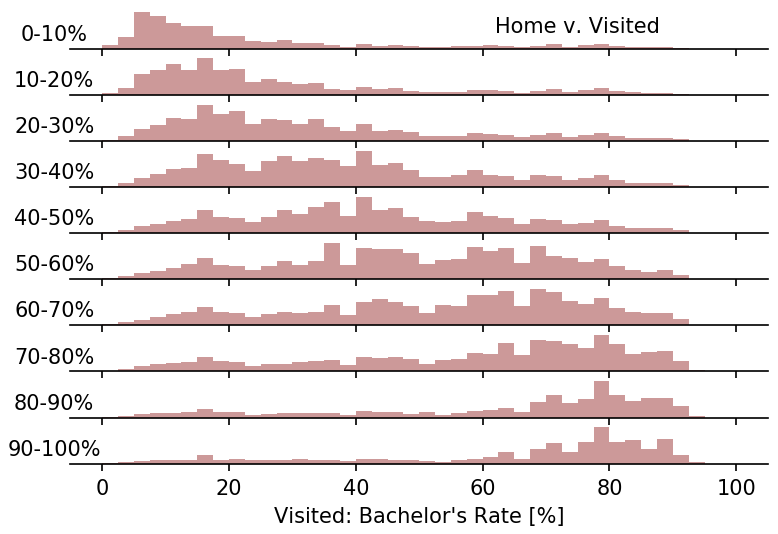

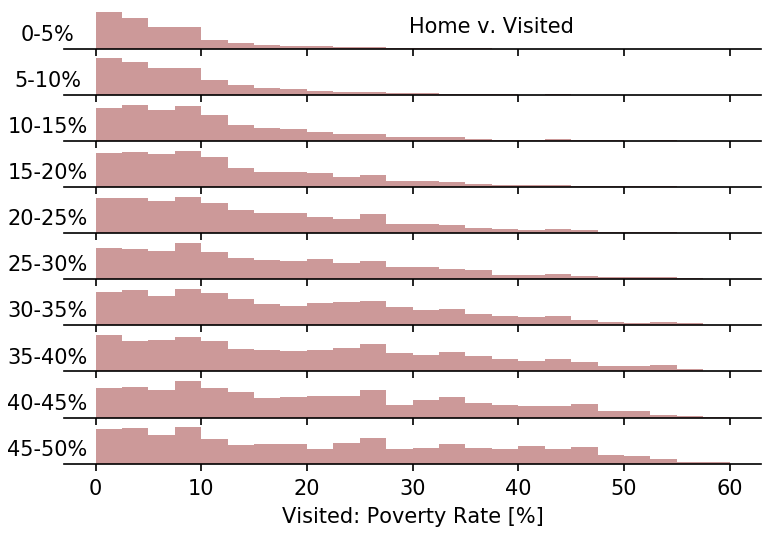

In [71]:
for k, l, N, S, M in [["BA_PCT", "Bachelor's Rate [%]", 10, 10, 100],
                      ["POV_PCT", "Poverty Rate [%]", 10, 5, 60]]:

    fig, ax = plt.subplots(N, 1)

    for a0 in range(N):

        cross[(cross[k] // S) == a0][k + "_o"].hist(bins = np.arange(0, M + 1, 2.5),
                                                     weights = cross[(cross[k] // S) == a0]["WP"],
                                                     ax = ax[a0], normed = True, color = "maroon", alpha = 0.4)
        ax[a0].spines['left'].set_visible(False)
        ax[a0].spines['right'].set_visible(False)
        ax[a0].spines['top'].set_visible(False)
        # ax[a0].set_ylabel("Decile " + str(a0+1), rotation = 0, labelpad=20)
        ax[a0].set_yticks([])
        ax[a0].grid(False)

        ax[a0].annotate("{}-{}%".format(a0*S, (a0+1)*S), xy = (0, 0), ha = "center",
                       textcoords = "offset points", xytext = (-23, 4))


    ax[0].annotate("Home v. Visited", xy = (0.75 * (N*S), 0), ha = "center",
                   textcoords = "offset points", xytext = (0, 8))
    ax[a0].set_xlabel("Visited: " + l)

# from matplotlib.colors import LogNorm

if 1:
    
    for k, v in {"POV_PCT" : "Poverty Rate[%]",
                 "BA_PCT"  : "Bachelor's Degree [%]"}.items():
        
        maxi = 80 if k == "POV_PCT" else 100
        
        H, xedges, yedges = np.histogram2d(cross[k], cross[k + "_o"], weights = cross["WP"],
                                           bins = 50, range = [[0, maxi], [0, maxi]], normed = True)

        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(H, interpolation='nearest', origin='low', cmap = "Blues",
                  norm = LogNorm(vmin = 1e-5, vmax = 5e-3),
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        
        ax.set_xlabel(v)
        ax.set_ylabel("Visited")
        
        ax.figure.savefig("figs/cross_{}.png".format(k))
        
        # plt.close("all")


In [11]:
for v in census_vals:

    print(v, smf.wls(formula = "{} ~ {}_o".format(v, v), 
                     weights = cross["WP"], data = cross).fit().rsquared)

HS_PCT 0.148051834676
TOTAL_POP 0.0273025673186
PCT_UNEMP 0.16775960202
PCT_HISP 0.165509521027
BA_PCT 0.197470901849
POV_PCT 0.137567571633
MHI 0.141405734039
ADV_PCT 0.15753935847
PCT_BLACK 0.281178407806


## A Biased Distribution

In [12]:
homes = pd.read_sql("SELECT geoid, COUNT(*) N FROM homes WHERE nhome > 2 GROUP BY geoid;", con = tr_con)
homes = homes.rename(columns = {"geoid" : "GEOID", "n" : "N"}).set_index("GEOID")
homes = pd.concat([homes, data], axis = 1)
homes["Fraction Sampled"] = homes.N / homes.TOTAL_POP

homes.fillna(0, inplace = True)

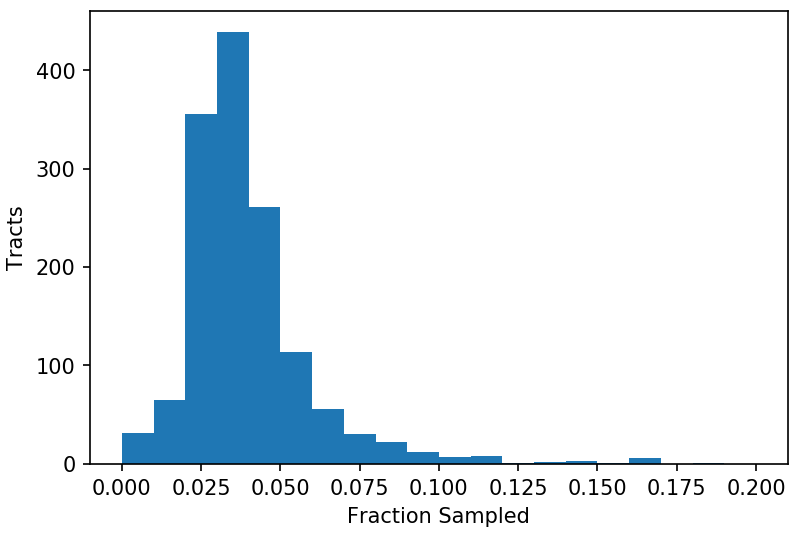

In [13]:
ax = homes["Fraction Sampled"].hist(bins = np.arange(0, 0.201, 0.01))
ax.set_xlabel("Fraction Sampled")
ax.set_ylabel("Tracts")
ax.grid(False)

ax.figure.savefig("figs/sample_fraction.pdf")

In [14]:
for k, v in census_labels.items():
    
    maxi = 101 if k != "MHI" else 200

    ax = homes[k].hist(bins = np.arange(0, maxi, maxi/20), weights = homes["TOTAL_POP"], figsize = (4, 2.5),
                       color = "green", alpha = 0.5, normed = True, label = "Census")

    homes[k].hist(bins = np.arange(0, maxi, maxi/20), weights = homes.N, 
                  color = "blue", alpha = 0.5, normed = True, ax = ax, label = "Cell Traces")

    ax.set_xlabel(v)
    ax.set_ylabel("Density")
    ax.grid(False)
    ax.legend(frameon = False)
    
    ax.figure.savefig("figs/bias_{}.pdf".format(k))
    
    plt.close("all")